# 1. Импорт библиотек

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_validate
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
import os

pd.options.mode.chained_assignment = None

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
PATH_to_file = '/kaggle/input/sf-dst-scoring/'

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [3]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# 2. Импорт данных

In [4]:
df_train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
df_test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [5]:
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.sample(3))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.sample(3))
print('Размерность sample_submission: ', sample_submission.shape)
display(sample_submission.sample(3))

Размерность тренировочного датасета:  (73799, 19)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
9241        9059  16JAN2014       SCH   F   49   N        N                0   
22379      91298  07APR2014       SCH   F   47   N        N                0   
60343      27371  03FEB2014       GRD   F   27   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
9241           0  -2.555619                7             40             1   
22379          1  -2.421189                2             70             1   
60343          0  -1.379069                4             60             2   

       work_address  income  sna  first_time foreign_passport  default  
9241              1   50000    1           4                N        0  
22379             2   48000    1           3                N        1  
60343             3   40000    4           1                N        0

Размерность тестового датасета:  (36349, 18)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
13231      76486  24MAR2014       GRD   M   27   N        N                0   
29344      44607  21FEB2014       SCH   F   31   N        N                0   
24502     108606  28APR2014       GRD   M   50   Y        Y                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
13231          1  -2.584352                0             80             2   
29344          0  -2.129613                1             50             1   
24502          0  -2.387028                2             80             2   

       work_address  income  sna  first_time foreign_passport  
13231             3   90000    1           4                Y  
29344             2   25000    1           3                N  
24502             3   70000    1           3                N

Размерность sample_submission:  (24354, 2)


client_id   default
12046      82964  0.964188
9101       44266  0.388472
12221      37104  0.559999

In [6]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
#df_train['Train'] = 1 # помечаем где у нас трейн
#df_test['Train'] = 0 # помечаем где у нас тест

#df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
# Объединение датасетов является потенциальной опасностью для даталиков!

# 3. Предварительный анализ данных

In [7]:
pandas_profiling.ProfileReport(df_train)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
pandas_profiling.ProfileReport(df_test)

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Выведу сводную информацию по датасетам
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

(None, None)

    Вывод по предварительному анализу:
        В тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Всего 19 переменных, из них 1 - временной ряд, 6 бинарных (среди них целевая переменная - default), 6 категориальных и 6 числовых. Всего пропусков в трэйне и тесте 478 (0.4%), все пропуски в переменной education. client_id уникальный числовой признак, который не является информативным.

Описания полей датасета

    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту


In [10]:
# Внесу данные в списки

# временной ряд (1)
time_cols = ['app_date']

# бинарные переменные (default не включаем в список) (5)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные (Train не включаю в список, так как мы сами его добавили) (6)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# числовые переменные (6)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income','days']

# client_id не включаю в списки

# 4. Анализ по переменным

### Age

    Столбец возраст имеет 52 уникальных значения.

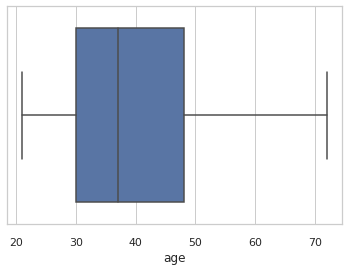

In [11]:
# Посмотрю на боксплот для признака
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_train['age'])

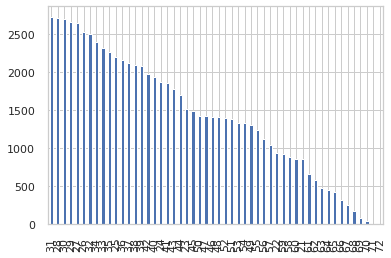

In [12]:
df_train['age'].value_counts().plot.bar();

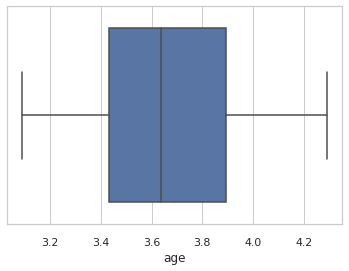

In [13]:
# Посмотрю на боксплот для логарифма признака
ax = sns.boxplot(x=np.log(df_train['age'] + 1))

In [14]:
df_train['age'] = np.log(df_train['age'] + 1)
df_test['age'] = np.log(df_test['age'] + 1)

Резюме Age:

    Выбросов по квартилям нет. Есть правосторонний перекос - это логично, т.к. молодое поколение более финансово активно.
    Возьму логарифм от признака, т.к. перекос немного меньше.

### Decline_app_cnt

    имеет 24 уникальных значения, минимальное - 0 (их 83%), максимальное - 33.

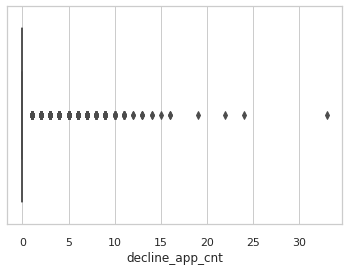

In [15]:
# Посмотрю на боксплот для признака
ax = sns.boxplot(x=df_train['decline_app_cnt'])

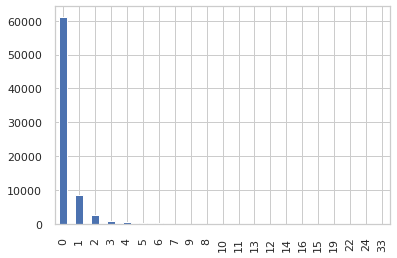

In [16]:
# Посмотрю на гистограмму для признака
df_train['decline_app_cnt'].value_counts().plot.bar();

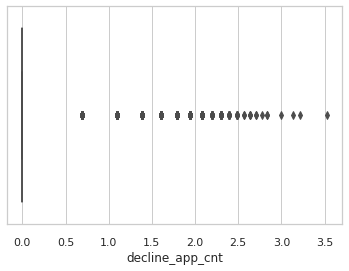

In [17]:
# Посмотрю на боксплот для логарифма признака
ax = sns.boxplot(x=np.log(df_train['decline_app_cnt'] + 1))

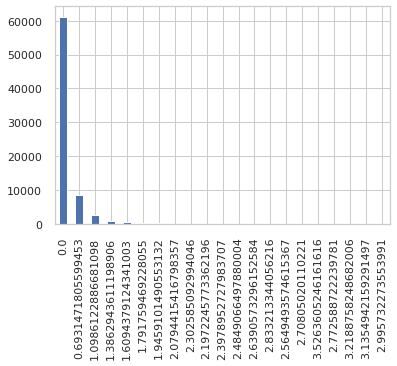

In [18]:
# Посмотрю на гистограмму для логарифма признака
np.log(df_train['decline_app_cnt'] + 1).value_counts().plot.bar();

In [19]:
df_train.decline_app_cnt.describe()

count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64

In [20]:
df_train['decline_app_cnt'] = np.log(df_train['decline_app_cnt'] + 1)
df_test['decline_app_cnt'] = np.log(df_test['decline_app_cnt'] + 1)

Резюме по decline_app_cnt:

    Все значения отличные от нуля являются выбросами. Возьму логарифм от переменной.

### Bki_request_cnt

In [21]:
df_train.bki_request_cnt.describe()

count    73799.000000
mean         2.000339
std          2.252073
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         53.000000
Name: bki_request_cnt, dtype: float64

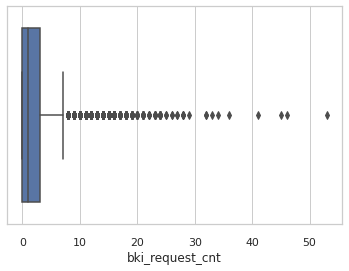

In [22]:
# Посмотрю на боксплот для признака
ax = sns.boxplot(x=df_train['bki_request_cnt'])

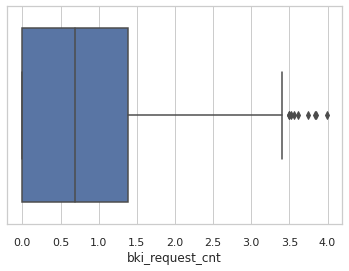

In [23]:
# Посмотрю на боксплот для логарифма признака
ax = sns.boxplot(x=np.log(df_train['bki_request_cnt'] + 1))

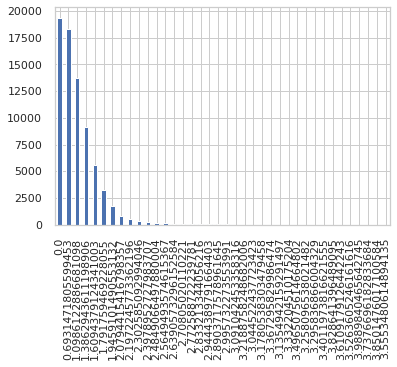

In [24]:
# Посмотрю на гистограмму для логарифма признака
np.log(df_train['bki_request_cnt'] + 1).value_counts().plot.bar();

In [25]:
df_train['bki_request_cnt'] = np.log(df_train['bki_request_cnt'] + 1)
df_test['bki_request_cnt'] = np.log(df_test['bki_request_cnt'] + 1)

Резюме bki_request_cnt:

    Взял логарифм, выбросов не много, не стал удалять


### Income

    Имеет сильный правосторонний перекос.

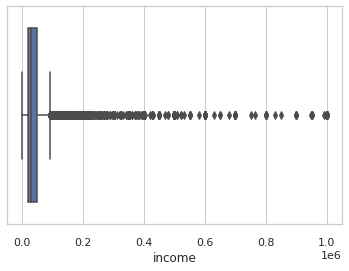

In [26]:
# Посмотрю на боксплот для признака
ax = sns.boxplot(x=df_train['income'])

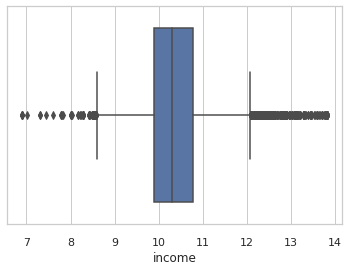

In [27]:
# Посмотрю на боксплот для логарифма признака
ax = sns.boxplot(x=np.log(df_train['income'] + 1))

In [28]:
df_train['income'] = np.log(df_train['income'] + 1)
df_test['income'] = np.log(df_test['income'] + 1)

Резюме income:

    Распределение логнормальное - взял логарифм, выбросов очень много и слева и справа даже после логарифмирования, удалять их пока не буду. Разберусь после построения модели.

### Score_bki

    имеет нормальное распределение.

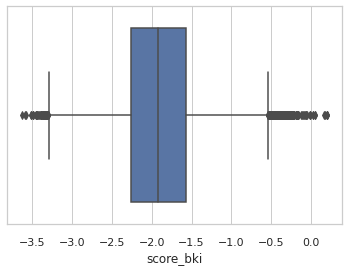

In [29]:
# Посмотрю на боксплот для признака
ax = sns.boxplot(x=df_train['score_bki'])

Резюме score_bki:

    Распределение нормальное. Выбросов мало, удалять пока ничего не буду.

### Sna

    имеет 4 уникальных значения

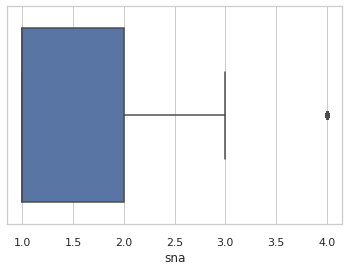

In [30]:
# Посмотрю на боксплот для признака
ax = sns.boxplot(x=df_train['sna'])

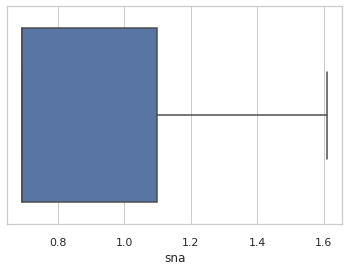

In [31]:
# Посмотрю на боксплот для логарифма признака
ax = sns.boxplot(x=np.log(df_train['sna'] + 1))

Резюме sna:

    Распределение смещено вправо - скорее логнормальное. Не стал брать логарифм. Всего 4 значения. Это категориальный признак.

### First_time

    имеет 4 уникальных значения

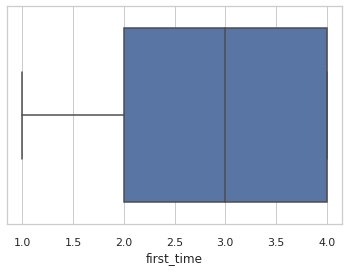

In [32]:
# Посмотрю на боксплот для признака
ax = sns.boxplot(x=df_train['first_time'])

Резюме first_time:

    Распределение смещено влево - нормальное. Выбросов нет. Всего 4 значения это категориальный признак.

### Region_rating

    

Резюме region_rating:

    Имеет 7 уникальных значений. Это категориальный признак.

### Education

здесь 5 категорий, они представлены не равномерно, имеет 478 пропусков - заполню их значением none. Идея на будущее: можно обучить модель определять значение пропусков, т.е. сначала целевой переменной обозначить образование.

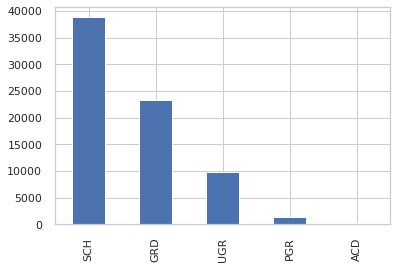

In [33]:
# Посмотрю на гистограмму признака
df_train['education'].value_counts().plot.bar();

In [34]:
# Заполню пропуски значением none
df_train['education'] = df_train['education'].fillna('none')
df_test['education'] = df_test['education'].fillna('none')

### App_date

имеет 120 уникальных значений.

In [35]:
# Преобразую формат признака
df_train.app_date = pd.to_datetime(df_train.app_date, format='%d%b%Y')
df_test.app_date = pd.to_datetime(df_test.app_date, format='%d%b%Y')

In [36]:
# Найду начало и конец периода нашего датасета
start = df_train.app_date.min()
end = df_train.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [37]:
# Создам новый признак - номер дня с 1 января
df_train['days'] = (df_train.app_date - start).dt.days.astype('int')
df_test['days'] = (df_test.app_date - start).dt.days.astype('int')

### Все остальные признаки были рассмотрены при выполнении задания на платформе СкилФэктори.

### Оценка корреляции

    Домашний и рабочий адреса имеют сильную корреляцию (около 0.8) по всем методикам рассчёта.
    По методике Phik: Car и car_type имеют высокую корреляцию (около 0.8); first_time и sna имеют корреляцию около 0.7. По методике Cramer's V заметна корреляция в тех же парах - попробую перед обучением эти столбцы попеременно отключать. 
    Отключение не дало существенных приростов результатов метрик.

### Значимость непрерывных переменных по ANOVA F test

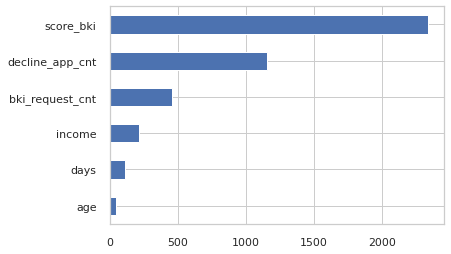

In [38]:
temp_df = df_train
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Вывод: score_bki самый значимый показатель по ANOVA F test, age наименее значимый параметр.

### Значимость категориальных и бинарных переменных

In [39]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    
# убедимся в преобразовании    
df_train.sample(3)

client_id   app_date education  sex       age  car  car_type  \
63227      20801 2014-01-28       UGR    1  3.367296    1         1   
72676      76324 2014-03-24       UGR    0  3.465736    1         1   
35000      70850 2014-03-19       SCH    0  4.219508    0         0   

       decline_app_cnt  good_work  score_bki  bki_request_cnt  region_rating  \
63227         0.000000          0  -1.669008         0.000000             40   
72676         1.098612          0  -1.044144         1.791759             40   
35000         0.000000          0  -1.758900         0.000000             40   

       home_address  work_address     income  sna  first_time  \
63227             2             3  10.596660    2           2   
72676             1             2  10.714440    1           3   
35000             2             3  10.021315    2           3   

       foreign_passport  default  days  
63227                 0        1    27  
72676                 0        0    82  
35000                 0        0    77

In [40]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df_test[column] = label_encoder.fit_transform(df_test[column])
    
# убедимся в преобразовании    
df_test.sample(3)

client_id   app_date education  sex       age  car  car_type  \
30694      95924 2014-04-12       GRD    0  3.663562    1         1   
6516        2260 2014-01-07       SCH    0  4.043051    0         0   
23503      61309 2014-03-11       SCH    0  3.784190    0         0   

       decline_app_cnt  good_work  score_bki  bki_request_cnt  region_rating  \
30694         0.000000          1  -1.705669         0.000000             60   
6516          0.693147          0  -2.437486         1.098612             60   
23503         0.000000          0  -1.550030         0.000000             40   

       home_address  work_address     income  sna  first_time  \
30694             2             3  10.596660    1           4   
6516              2             3   9.012011    1           3   
23503             1             1  10.308986    4           1   

       foreign_passport  days  
30694                 0   101  
6516                  0     6  
23503                 0    69

In [41]:
# Пронумерую значения в столбце education
df_train.education = df_train.education.apply(lambda x: 0 if x=='SCH' else 1 if x=='GRD' else 2 if x=='UGR'
else 3 if x=='PGR' else 4 if x=='ACD' else 5)

df_test.education = df_test.education.apply(lambda x: 0 if x=='SCH' else 1 if x=='GRD' else 2 if x=='UGR'
else 3 if x=='PGR' else 4 if x=='ACD' else 5)

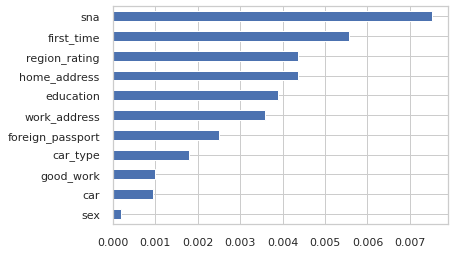

In [42]:
# Определю значимость бинарных признаков по Mutual information тесту
temp_df = df_train
imp_cat = pd.Series(mutual_info_classif(temp_df[bin_cols + cat_cols], temp_df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Вывод:

    Самым значимым признаком по Mutual information тесту является связь заемщика с клиентами банка (sna), наименее значимым является sex.

# 5. Подготовка данных к машинному обучению

### Категориальные признаки

In [43]:
# Реализую метод OneHotEncoder
X_cat = OneHotEncoder(sparse=False).fit_transform(df_train[cat_cols].values)
y_cat = OneHotEncoder(sparse=False).fit_transform(df_test[cat_cols].values)

print(X_cat.shape)
print(y_cat.shape)

(73799, 27)
(36349, 27)


### Стандартизация для числовых признаков

In [44]:
# Сгенерирую полиномы числовых переменных
poly = PolynomialFeatures(2)

X_p = poly.fit_transform(df_train[num_cols].values)
y_p = poly.fit_transform(df_test[num_cols].values)

In [45]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(X_p)
y_num = StandardScaler().fit_transform(y_p)

X_num.shape, y_num.shape

((73799, 28), (36349, 28))

# 6. Построение модели

Объединю стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство. Отделю признаки от целевой переменной.


In [46]:
X = np.hstack([X_num, df_train[bin_cols].values, X_cat])
y = df_train['default'].values

id_test = df_test['client_id']
test = np.hstack([y_num, df_test[bin_cols].values, y_cat])

In [47]:
X.shape, y.shape,

((73799, 60), (73799,))

In [48]:
# Воспользуюсь специальной функцие train_test_split для разбивки тестовых данных
# выделю 20% данных на валидацию (параметр test_size = 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

In [49]:
# Проверю размерности
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 60), (14760, 60), (59039,), (14760,))

### Обучение и метрики

In [50]:
# Модель_1

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

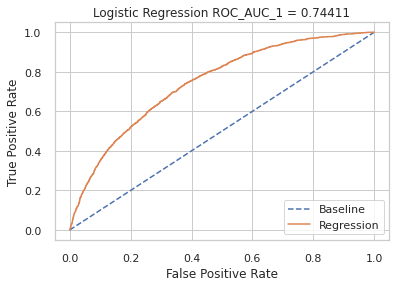

In [51]:
probs_1 = model_1.predict_proba(X_test)
probs_1 = probs_1[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs_1)
roc_auc_1 = roc_auc_score(y_test, probs_1)

# Визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC_AUC_1 = %0.5f' % roc_auc_1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [52]:
y_pred = model_1.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Accuracy = {:.5f}\nPrecision = {:.5f}\nRecall = {:.5f}\nF1-score = {:.5f}'.format(acc, precision, recall, f1))

Accuracy = 0.87527
Precision = 0.42553
Recall = 0.02189
F1-score = 0.04164


In [53]:
# confusion matrix
cm_1 = confusion_matrix(y_test, y_pred)
cm_1

array([[12879,    54],
       [ 1787,    40]])

### Подбор гиперпараметров (регуляризация)

Попробую улучшить работу модели с помощью регуляризации

In [54]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

clf = GridSearchCV(model_1, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/line

Лучший penalty: l2
Лучшее C: 1291.5496650148827


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [55]:
# Модель 2. Добавлю параметры регуляризации

model_2 = LogisticRegression(penalty='l2', C=1291.5496650148827, max_iter=800)
model_2.fit(X_train, y_train)

LogisticRegression(C=1291.5496650148827, max_iter=800)

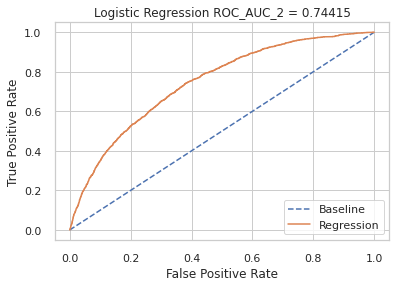

In [56]:
probs_2 = model_2.predict_proba(X_test)
probs_2 = probs_2[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs_2)
roc_auc_2 = roc_auc_score(y_test, probs_2)

# Визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC_AUC_2 = %0.5f' % roc_auc_2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [57]:
y_pred = model_2.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Accuracy = {:.5f}\nPrecision = {:.5f}\nRecall = {:.5f}\nF1-score = {:.5f}'.format(acc, precision, recall, f1))

Accuracy = 0.87554
Precision = 0.44681
Recall = 0.02299
F1-score = 0.04373


In [58]:
# confusion matrix
cm_2 = confusion_matrix(y_test, y_pred)
cm_2

array([[12881,    52],
       [ 1785,    42]])

Вывод:

Модель_2 очень плохая, несмотря на то, что целевая метрика ROC-AUC достаточно высокая (0.744).

Дело в том что:

    Из матрицы ошибок видно, что модель плохо угадывает дефолтных клиентов (52 из 1785). Об этом также свидетествует метрика полнота recall = 0.02299. Таким образом все клиенты попали в ошибку второго рода, а это очень плохо для банка, так как мы будем выдавать кредиты людям которые их не смогут вернуть.
    В тоже время, целевая переменная площадь под ROC кривой показывает высокое значение. Дело в том, что эта кривая плохо оценивает эффективность алгоритма на несбалансированных данных.

### Использую class_weight="balanced"

Автоматически настрою веса классов во входных данных

In [59]:
# Модель 3

model_3 = LogisticRegression(penalty='l2', C=1291.5496650148827, class_weight="balanced", max_iter=800)
model_3.fit(X_train, y_train)

LogisticRegression(C=1291.5496650148827, class_weight='balanced', max_iter=800)

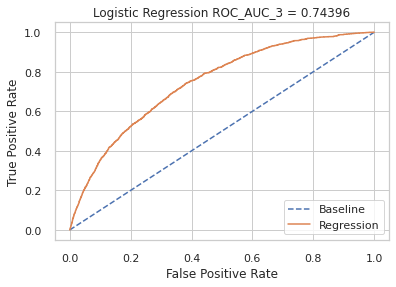

In [60]:
probs_3 = model_3.predict_proba(X_test)
probs_3 = probs_3[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs_3)
roc_auc_3 = roc_auc_score(y_test, probs_3)

# Визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC_AUC_3 = %0.5f' % roc_auc_3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [61]:
y_pred = model_3.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('Accuracy = {:.5f}\nPrecision = {:.5f}\nRecall = {:.5f}\nF1-score = {:.5f}'.format(acc, precision, recall, f1))

Accuracy = 0.66938
Precision = 0.22609
Recall = 0.68966
F1-score = 0.34054


In [62]:
# confusion matrix
cm_3 = confusion_matrix(y_test, y_pred)
cm_3

array([[8620, 4313],
       [ 567, 1260]])

<AxesSubplot:>

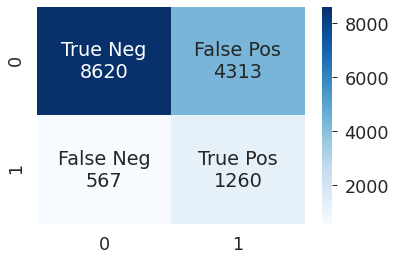

In [63]:
# Визуализирую confusion matrix
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_3.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm_3, annot=labels, fmt='', cmap='Blues')

Вывод:

    Recall и F1-score подросли по сравнению со второй моделью, а accuracy и precision упали. Precision просела потому что модель стала работать лучше. Клиенты из TN переместились в FP. На матрице ошибок виден не такой большой провал по ошибке второго рода как на второй модели.

### Feature engineering

Существенного прироста метрик не дал, поэтому он закомментирован, метрики представлены в виде markdown в конце раздела.

In [64]:
# сгенерирую новые признаки

#df_train['a'] = ((df_train['income']+df_train['decline_app_cnt'])**2)/4
#df_train['b'] = ((df_train['age']/(1+df_train['decline_app_cnt']))**2)/4
#df_train['c'] = np.log(((df_train['decline_app_cnt']+df_train['bki_request_cnt'])**2)/4 + 1)
#df_train['d'] = np.log(((df_train['education']*df_train['income']/df_train['work_address'])**2)/3 + 1)
#df_train['e'] = ((df_train['bki_request_cnt']+df_train['income']*df_train['home_address'])**3)/25

#df_test['a'] = ((df_test['income']+df_test['decline_app_cnt'])**2)/4
#df_test['b'] = ((df_test['age']/(1+df_test['decline_app_cnt']))**2)/4
#df_test['c'] = np.log(((df_test['decline_app_cnt']+df_test['bki_request_cnt'])**2)/4 + 1)
#df_test['d'] = np.log(((df_test['education']*df_test['income']/df_test['work_address'])**2)/3 + 1)
#df_test['e'] = ((df_test['bki_request_cnt']+df_test['income']*df_test['home_address'])**3)/25

In [65]:
# числовые переменные
#num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income','days', 'a', 'b', 'c', 'd', 'e']

In [66]:
#poly = PolynomialFeatures(2)

#X_p = poly.fit_transform(df_train[num_cols].values)
#y_p = poly.fit_transform(df_test[num_cols].values)

In [67]:
# Стандартизация числовых переменных

#X_num = StandardScaler().fit_transform(X_p)
#y_num = StandardScaler().fit_transform(y_p)

In [68]:
#X = np.hstack([X_num, df_train[bin_cols].values, X_cat])
#y = df_train['default'].values

In [69]:
# Воспользуюсь специальной функцие train_test_split для разбивки тестовых данных
# выделю 20% данных на валидацию (параметр test_size = 0.2)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

In [70]:
# Проверю размерности
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [71]:
# Модель 4

#model_4 = LogisticRegression(penalty='l2', C=1291.5496650148827, class_weight="balanced", max_iter=800)
#model_4.fit(X_train, y_train)

In [72]:
#probs_4 = model_4.predict_proba(X_test)
#probs_4 = probs_4[:, 1]


#fpr, tpr, threshold = roc_curve(y_test, probs_4)
#roc_auc_4 = roc_auc_score(y_test, probs_4)

# Визуализация ROC AUC
#plt.figure()
#plt.plot([0, 1], label='Baseline', linestyle='--')
#plt.plot(fpr, tpr, label='Regression')
#plt.title('Logistic Regression ROC_AUC_4 = %0.5f' % roc_auc_4)
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.legend(loc='lower right')
#plt.show()

ROC_AUC_4 = 0.74308

In [73]:
#y_pred = model_4.predict(X_test)
#acc = accuracy_score(y_test, y_pred)
#precision = precision_score(y_test, y_pred)
#recall = recall_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)
#print('Accuracy = {:.5f}\nPrecision = {:.5f}\nRecall = {:.5f}\nF1-score = {:.5f}'.format(acc, precision, recall, f1))

    Accuracy = 0.67053
    Precision = 0.22659
    Recall = 0.68856
    F1-score = 0.34097

In [74]:
# confusion matrix
#cm_4 = confusion_matrix(y_test, y_pred)
#cm_4

    array([[8639, 4294],
           [ 569, 1258]])

# Cross validate

In [75]:
# Выполню кросс валидацию

temp_vec = cross_validate(model_3, X, y, cv=10, scoring='roc_auc', return_train_score=True)

In [76]:
temp_vec

{'fit_time': array([4.41417623, 5.61165118, 5.66172767, 5.59909272, 4.84675837,
        5.24072599, 5.08152103, 5.36626577, 6.02028894, 5.4762361 ]),
 'score_time': array([0.00760198, 0.02029634, 0.00841999, 0.00865364, 0.00760508,
        0.00749922, 0.00727177, 0.00822759, 0.00712729, 0.00733972]),
 'test_score': array([0.74160784, 0.73650389, 0.72483039, 0.7343025 , 0.7401525 ,
        0.73603876, 0.74170987, 0.75458991, 0.71908944, 0.72705054]),
 'train_score': array([0.73703605, 0.7375382 , 0.73868487, 0.73774446, 0.73715469,
        0.7375503 , 0.73699241, 0.73554474, 0.7394307 , 0.73866669])}

In [77]:
test_score = [0.74160784, 0.73650389, 0.72483039, 0.7343025 , 0.7401525 ,
              0.73603876, 0.74170987, 0.75458991, 0.71908944, 0.72705054]

sum(test_score) / 10

0.735587564

In [78]:
train_score = [0.73703605, 0.7375382 , 0.73868487, 0.73774446, 0.73715469,
               0.7375503 , 0.73699241, 0.73554474, 0.7394307 , 0.73866669]

sum(train_score) / 10

0.737634311

Вывод:

Из разбивки на 10 фолдов видно, что тест скор проседает на 2, 9 и 10 фолдах. В трэйн скоре такой закономерности не прослеживается. Среднее значение трэйн скора немного выше чем тест скора.

Что бы это могло значить?

# Submission

Прежде чем сделать submission заново загружу датасет произведу всю предобработку, избавлюсь от наименее важных столбцов (age и sex). Избавлюсь от выбросов в income и bki_request_cnt.

In [79]:
# Обучу модель_3 на всём трейне
model_3 = LogisticRegression(penalty='l2', C=1291.5496650148827, class_weight="balanced", max_iter=800)
model_3.fit(X, y)

LogisticRegression(C=1291.5496650148827, class_weight='balanced', max_iter=800)

In [80]:
# Сделаю предсказание для теста
y_pred = model_3.predict(test)

In [81]:
# Создам submission
my_submission = pd.DataFrame({'client_id': id_test,
                              'default': y_pred})
my_submission.to_csv('submission.csv', index=False)

In [82]:
my_submission.head(10)

client_id  default
0      74835        0
1      17527        1
2      75683        0
3      26883        0
4      28862        0
5      99881        1
6      26630        1
7      79934        0
8      16605        0
9     105449        0